## Segmentation with U-Net


**Import required libraries.**

In [1]:
import os
import tqdm
import zipfile
import requests
from glob import glob
from pathlib import Path

import numpy as np
import seaborn as sns
import imageio.v2 as imageio
from matplotlib import colors
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.measure import label
from skimage.util import random_noise
from scipy.optimize import linear_sum_assignment
from skimage.metrics import contingency_table, peak_signal_noise_ratio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Temporary fix for importing `skimage.segmentation` on Kaggle**

As of 30th November 2023, Kaggle has an incompatible combination of the libraries `scipy` and `skimage.segmentation`. The next hack is aimed to fix to it.


In [ ]:
# let's check if the import works or not
from skimage.segmentation import find_boundaries, watershed

In [3]:
# DO NOT CHANGE
def fix_scipy_imports(path="/opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py"):
    with open(path, "r") as f:
        file = f.read()

    i = file.find("\n", 49)
    new_file = file[:i+1] + "# " + file[i+1:]

    with open(path, "w") as f:
        f.write(new_file)

In [4]:
# the issue should now be resolved. let's try it out.
try:
    from skimage.segmentation import find_boundaries, watershed
except ImportError:
    fix_scipy_imports()
    from skimage.segmentation import find_boundaries, watershed

**The normal exercise continues here.**

In [5]:
# create a root folder where to save the data for this exercise in Kaggle
root_folder = "/kaggle/working/dlforcv-ex4"
os.makedirs(root_folder, exist_ok=True)

## Segmentation

In the first part of the exercise we will implement the U-Net architecture and apply it to segment nuclei in fluorescence microscopy images. This is an important task in microscopy image analysis in order to identify and characterize cell morphology and dynamics. The data we are using is a subset of the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

### Data preparation

In [5]:
# download the data
data_folder = os.path.join(root_folder, "kaggle-data")
url = "https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    tmp_path = os.path.join(data_folder, "data.zip")
    with requests.get(url) as r:
        with open(tmp_path, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(tmp_path, "r") as f:
        f.extractall(data_folder)
    os.remove(tmp_path)
data_folder = os.path.join(data_folder, "dsb2018")
assert os.path.exists(data_folder)

**Data exploration**

The data is stored in the root folder `dsb2018` and contains the two subfolders `train` and `test` with train/test split. Each of these folders contains the folders `images` with the raw image data and `masks` with the instance masks. As a first step, we will visualize some of the images and labels from the training data.

In [6]:
image_paths = glob(os.path.join(data_folder, "train", "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(data_folder, "train", "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)

In [7]:
test_image_paths = glob(os.path.join(data_folder, "test", "images", "*.tif"))
test_image_paths.sort()
test_mask_paths = glob(os.path.join(data_folder, "test", "masks", "*.tif"))
test_mask_paths.sort()
assert len(test_image_paths) == len(test_mask_paths)

In [6]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [7]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

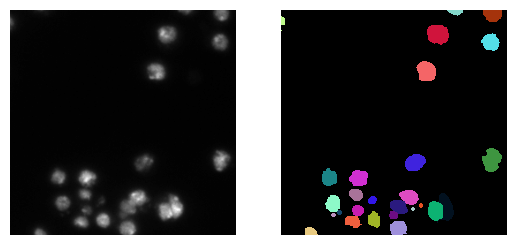

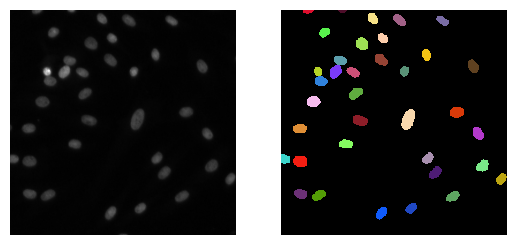

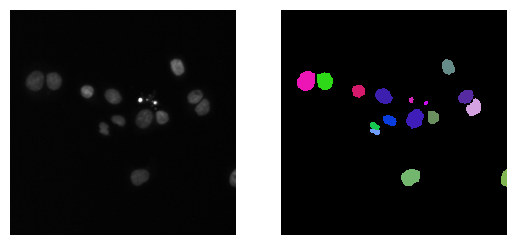

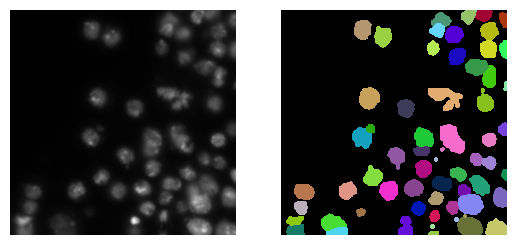

In [10]:
# plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

You should see 4 images with nuclei and the corresponding colored nuclei masks. To further understand and explain the data, we will answer the following questions:
- Do the ids assigned to the individual nuclei (= colors in the 2nd image column) have a fixed meaning? In other words, would the segmentation meaningfully change if we change shuffle the ids, so that all pixels labeled `1` are labeled `2` and so on?
- Can we directly use a U-Net to predict the mask ids? Why / Why not?

- The specific IDs assigned to each nucleus are arbitrary and used solely for distinguishing individual elements in the image. Changing these IDs would not impact the interpretation of the segmentation, as long as each nucleus remains consistently labeled across the analysis.
- A standard U-Net cannot directly predict unique IDs for individual nuclei in our microscopy images because it's designed for semantic segmentation, which doesn't differentiate between instances of the same class.

In [11]:
# we find how many images we have in the training set
# and find all (unique) shapes of the images in the training set
print(f"Number of images in the training set: {len(image_paths)}")
unique_dims = set()
for img_path in image_paths:
    img = imageio.imread(img_path)
    unique_dims.add(img.shape)
unique_dims

Number of images in the training set: 447


{(256, 256), (256, 320), (260, 347), (360, 360), (512, 640), (520, 696)}

**QUESTIONS**:
- Do all images have the same shape? If not, can this lead to problems?
- How could we deal with potential problems due to different image shapes?

- All the images do not seem to have the same shape. Using images with varying dimensions can be problematic for training a U-Net model because neural networks usually require a fixed input size.
- To handle this, the simplest strategy could be to resize the images to a consistent size.

In [12]:
# now we load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = [imageio.imread(img) for img in image_paths]
masks = [imageio.imread(mask_path) for mask_path in mask_paths]

In [13]:
ims_flat = np.concatenate([im.ravel() for im in images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
images = [(im.astype("float32") - mean) / std for im in images]

In [14]:
# we make a train validation split, use every 20th image for validation
train_images = [img for i, img in enumerate(images) if i%20 != 19]
train_masks = [mask for i, mask in enumerate(masks) if i%20 != 19]
val_images = [img for i, img in enumerate(images) if i%20 == 19]
val_masks = [mask for i, mask in enumerate(masks) if i%20 == 19]

In [15]:
print(f"Training Images: {len(train_images)}, Training Masks: {len(train_masks)}, Validation Images: {len(val_images)}, Validation Masks: {len(val_masks)}")

Training Images: 425, Training Masks: 425, Validation Images: 22, Validation Masks: 22


In [8]:
# finally, let's choose the appropriate torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Implement PyTorch dataset**

As a next step, we implement a `torch.utils.data.Dataset` to access the data for training. As you should have realized in the previous question, the images in our training set come in different sizes. But in order to assemble images into batches we need images of the same size. To solve this issue, we will subsample patches of size 256 x 256 (smallest image size) from the images in the dataset.

In [9]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]
              
                
      # make sure we have numpy arrays and add a channel dimension for the image data
#         image, mask = np.array(image), np.array(mask)
#         if image.ndim == 2:
#             image = image[None]
        
        # apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        return image, mask
        
    def __len__(self):
        return len(self.images)

As discussed in the lecture, we can't learn the instance segmentation directly. So we will first start with a semantic segmentation problem and train the U-Net to distinguish foreground (nucleus) from background pixels. In other words, the network should predict for each pixel whether it belongs to a nucleus or to the background. To this end, implement a `mask_transform` that converts the instance segmentation ground-truth into a binary target and pass it to the training dataset.

In [18]:
# we implement a transform that outputs the binary target 
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target
# HINT: the targets need to be "float32" values (for the BCE Loss coming ahead)
def mask_transform(mask):
    bin_img = (mask>0).astype(np.float32)[None]
    return torch.from_numpy(bin_img)
# Image transform
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert numpy array to torch.Tensor
])

train_dataset = NucleiDataset(train_images, train_masks, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = NucleiDataset(val_images, val_masks, image_transform=image_transform, mask_transform=mask_transform)

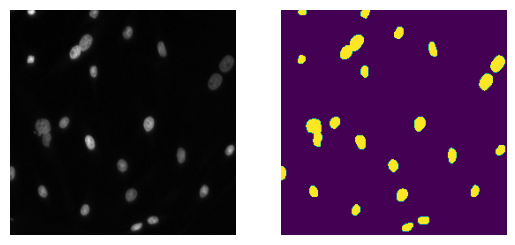

In [19]:
# we sample a few images from the dataset and verify that they are correct
import random
rand_idx = random.randint(0, len(train_dataset.images))
img, mask = train_dataset[rand_idx]

fig, ax = plt.subplots(1, 2)
ax[0].axis("off")
ax[0].imshow(np.squeeze(img), cmap='gray')
# visualize the masks with random colors
ax[1].axis("off")
ax[1].imshow(np.squeeze(mask))
plt.show()

The images you sample should look similar to this (using the standard colormap for the binarized mask):
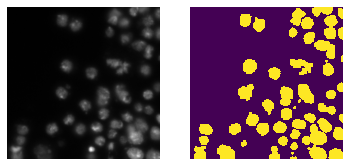

### Implement the U-Net

Next, we will implement a U-Net architecture inspired [Ronneberger et al.](https://arxiv.org/abs/1505.04597), see the image below.

Unlike in the publication / image we will use SAME convolutions, so that the input shape is the same as the output shape. This will introduce some boundary artifacts, but it will make implementing the rest of this exercise much simpler.
It also means that we don't need to crop the features passed on in the skip connections and can directly concatenate them.

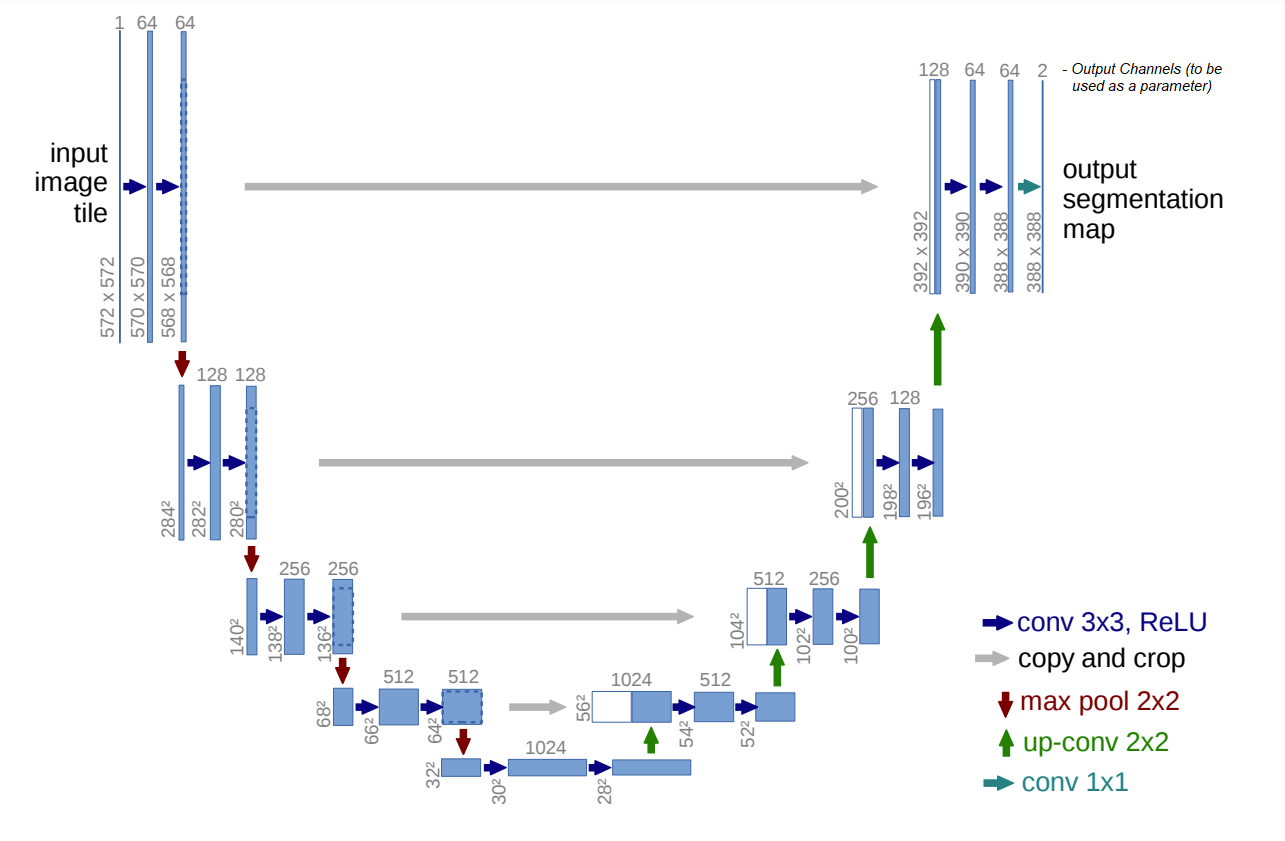



In [10]:
# We implement the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        super(UNet, self).__init__()

        # Encoder blocks
        self.enc_blocks = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        ])

        # Bottleneck block
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1), nn.ReLU()
        )

        # Decoder blocks
        self.dec_blocks = nn.ModuleList([
            nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2), nn.ReLU(),
                          nn.Conv2d(1024, 512, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), nn.ReLU(),
                          nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
                          nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()),
            nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
                          nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU())
        ])

        # Final 1x1 conv to get the segmentation map
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        skip_connections = []
        for enc_block in self.enc_blocks:
            x = enc_block(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        for i, dec_block in enumerate(self.dec_blocks):
            x = dec_block[0](x)  # Apply the transposed convolution
            skip_connection = skip_connections[-(i+1)]
            x = torch.cat((x, skip_connection), dim=1)  # Skip connection
            x = dec_block[1:](x)  # Apply the rest of the sequential block
        
        # Final segmentation map
        x = self.final_conv(x)
        return x

In [6]:
!pip install torchsummary
from torchsummary import summary

In [22]:
# We instantiate a unet and check that our architecture is correct by applying it to
# an input from the train loader
model = UNet()
model.to(device)
summary(model, (1,256,256))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 64, 256, 256]             640

              ReLU-2         [-1, 64, 256, 256]               0

            Conv2d-3         [-1, 64, 256, 256]          36,928

              ReLU-4         [-1, 64, 256, 256]               0

            Conv2d-5        [-1, 128, 128, 128]          73,856

              ReLU-6        [-1, 128, 128, 128]               0

            Conv2d-7        [-1, 128, 128, 128]         147,584

              ReLU-8        [-1, 128, 128, 128]               0

            Conv2d-9          [-1, 256, 64, 64]         295,168

             ReLU-10          [-1, 256, 64, 64]               0

           Conv2d-11          [-1, 256, 64, 64]         590,080

             ReLU-12          [-1, 256, 64, 64]               0

           Conv2d-13          [-1, 512, 32, 32]       1,180,160

             ReLU-14   

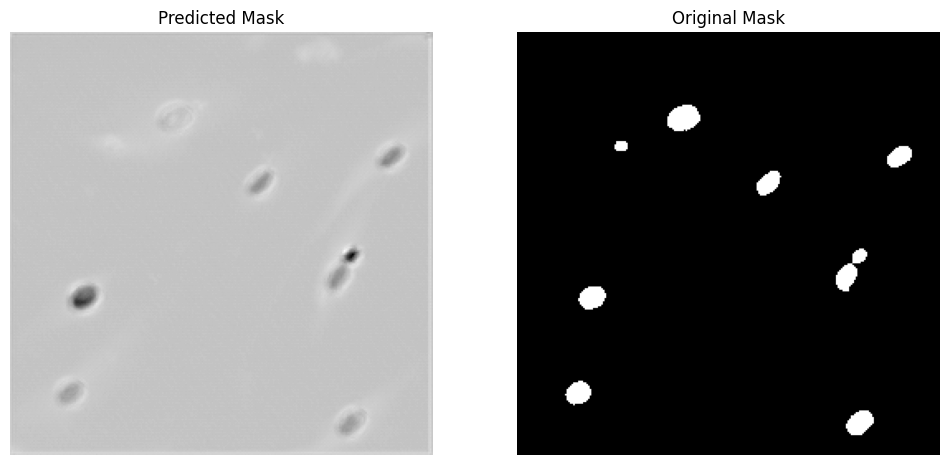

In [23]:
# We display the prediction
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
ex_img, ex_mask = next(iter(train_loader))

model.eval()
with torch.no_grad():
    ex_prediction = model(ex_img.to(device))
    
# Squeeze to remove the batch dimension and channel dimension for visualization
ex_predicted_mask = ex_prediction.squeeze(0).squeeze(0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ex_predicted_mask.cpu(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ex_mask.squeeze(0).squeeze(0).cpu(), cmap='gray')
plt.title("Original Mask")
plt.axis('off');

## Training

Now we can define the training functions, similar to the last exercises but adapted for segmentation, and then plot the results of loss and metrics.



In [11]:
# normalize a tensor to range [0, 1] (per channel).
# This is needed to properly display the tensor as an image in tensorboard
def normalize(tensor):
    eps = 1e-6
    normed = tensor.numpy()
    minval = normed.min(axis=(0, 2, 3), keepdims=True)
    normed = normed - minval
    maxval = normed.max(axis=(0, 2, 3), keepdims=True)
    normed = normed / (maxval + eps)
    return torch.from_numpy(normed)


# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
    
    return train_losses, train_accs, val_losses, val_accs


# plot the metrics
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training " + label.lower(), "Validation " + label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

We will use (per-pixel) binary cross entropy as a loss function. Pytorch offers to different implementations of this loss: [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

HINTS:
- The targets for BCE should be 'float32' values

QUESTIONS:
- What is the difference between the two different implementations?
- Which one do we need to use here, and why?

- BCELoss is used when inputs are probabilities (after sigmoid), while BCEWithLogitsLoss combines a sigmoid layer with BCELoss for raw score (logit) inputs.
- For U-Net without a final sigmoid activation (which is the case for our implementation), BCEWithLogitsLoss is preferable due to its numerical stability (handles the log-sum-exp operation internally, which helps in preventing underflow or overflow problems) and computational efficiency.

In [25]:
# TODO create the loss function
loss = nn.BCEWithLogitsLoss()

Next, we want to define a suitable metric for measuring the quality of the (binary) network prediction. We will use the [dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for this, which compares the intersection of prediction and target to their union.

In [12]:
# Now we implement the dice score as a function.

def dice_score(input_, target):
    
    # Apply sigmoid to bring the predictions into range [0, 1]
    input_sigmoid = torch.sigmoid(input_)
    
    # Calculate intersection and union
    intersection = (input_sigmoid * target).sum(dim=(2, 3))  # Sum over spatial dimensions
    union = input_sigmoid.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    # Compute Dice score
    dice = (2. * intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero

    # Compute average over channels
    dice_score_average = dice.mean(dim=1)  # Average over channels

    return dice_score_average.mean()  # Return mean dice score over the batch


In [205]:
# We check your dice implementation for an example model prediction and the corresponding target
dice_score(ex_prediction.cpu(), ex_mask)

tensor(0.0390)

100%|██████████| 10/10 [02:40<00:00, 16.02s/it]


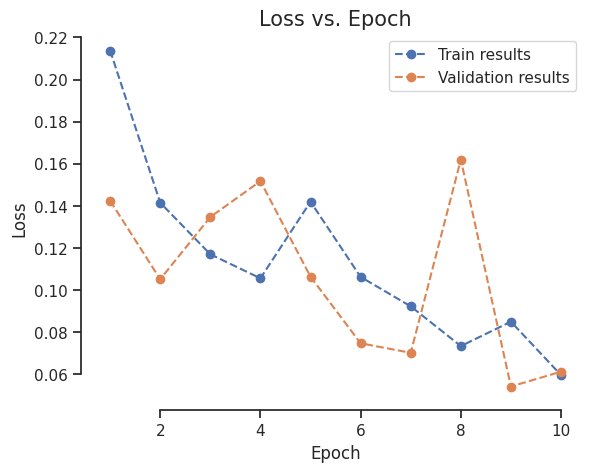

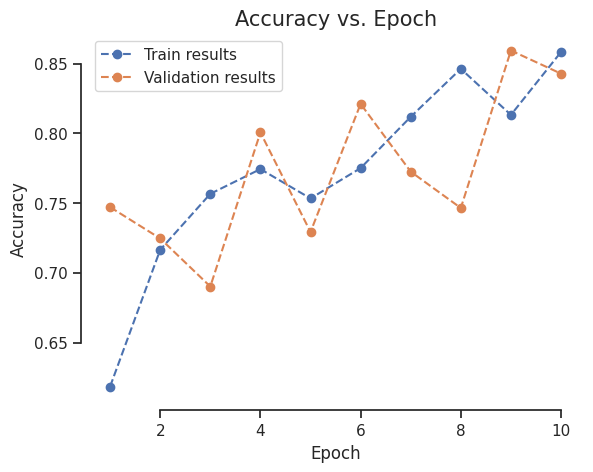

In [28]:
# We train the model for 10 epochs, 
# after the training, we check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = dice_score
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

## Evaluate on test data

Now, we will evaluate the **instance segmentation**  derived from the model predictions on the test data. To this end, we will use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)#Algorithms) to convert the (binarized) network predictions into an instance segmentation. We will use the implementation from [skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label).

The connected components algorithm, when applied to a binary image, identifies and groups pixels into sets based on their connectivity, effectively segmenting the image into distinct regions or "components." Each component consists of adjacent pixels sharing the same value (typically foreground pixels with a value of 1).


In [29]:
# We load and normalize the test images
test_images = [imageio.imread(img) for img in test_image_paths]
test_images = [(im.astype("float32") - mean) / std for im in test_images]
test_masks = [imageio.imread(mask_path) for mask_path in test_mask_paths]

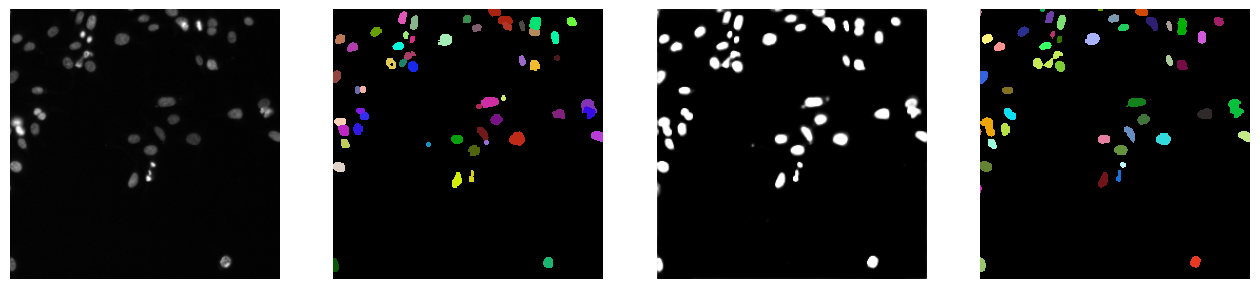

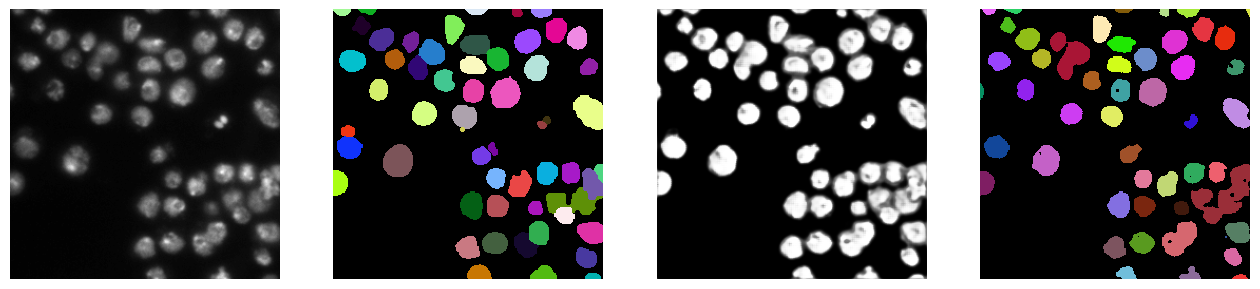

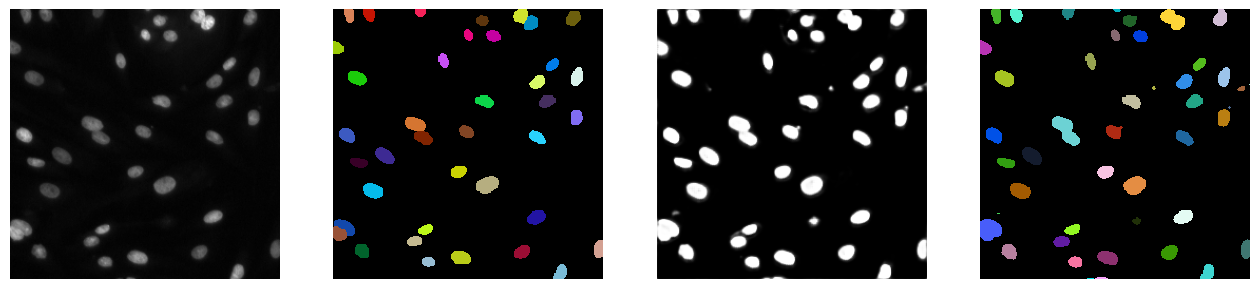

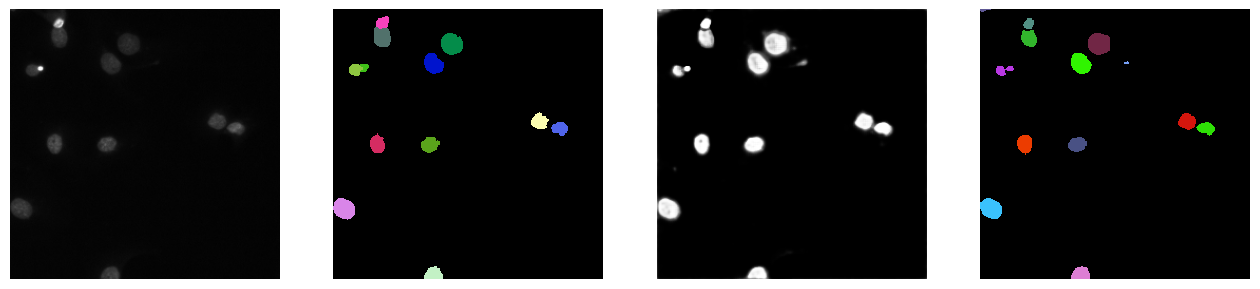

In [30]:
# We check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label(pred > 0.5)
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        plt.show()
        counter += 1

To measure the segmentation quality we compute the intersection over union of each object in the prediction and each object in the ground-truth (if they overlap at all). We then find the best match between ground-truth and predicted objects and count all best matches above a given threshold (here 0.5) as true positives (TP). The objects in the the ground-truth that do not have a match are counted as false negatives (FN), the objects in the prediction that do not have a match as false positives (FP).

We can then compute the F1-Score based on TP, FP and FN and use it as evaluation criterion to compare the quality of instance segmentation results.

In [13]:
# compute f1 score based on true positives, false positives and false negatives
def f1(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


# compute the matches between predicted object (seg) and ground-truth objects (mask)
def compute_scores(seg, mask):
    # the contingency table function computes the overlap (intersection) between all objects in the two segmentations 
    overlap = contingency_table(seg, mask).toarray()
    # compute the total number of pixels for each object
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    # normalize the overlap by the union to compute the IOU
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)
    # ignore matches with zero (= background)
    ious = ious[1:, 1:]
    # compute the number of true objects (in mask), predicted object (in seg)
    # and the maximal number of matches (minimum of the too)
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious


# compute the true positives (= matches with a iou bigger than the threshold)
def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    return tp


# compute the f1 score between predicted (seg) and ground-truth (mask) objects for the given threshold
def f1_score(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0
    n_true, n_matched, n_pred, scores = compute_scores(seg, mask)
    tp = compute_tps(scores, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    return f1(tp, fp, fn)

In [32]:
# Compute the average f1 score of all the test images
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # the model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        labels = label(pred > 0.5)

        f1s.append(f1_score(labels, mask))
print()
# print(f1s)
print("Mean f1 score:", np.mean(f1s))

100%|██████████| 50/50 [00:01<00:00, 32.17it/s]



Mean f1 score: 0.7473117437413898


Based on the examples we have visualized above, the biggest source of error seems to be the merging of multiple distinct objects/nuclei that're closely adjacent/touching into a single segment.

## Train with boundary channel

To avoid merges of touching nuclei, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation function. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [14]:
# We implement a transform that outputs an image with 3 values:
# 0 for backgorund, 1 for foreground (= nucleus) and 2 for boundary (boundary pixel between nucleus and background or between 2 nuclei)
# HINT: you can use skimage.segmentation.find_boundaries (already imported) to determine the boundary pixels
def label_transform(mask):
    # Create a transformed mask with the same shape as the original mask
    transformed_mask = np.zeros(mask.shape, dtype=np.int64)
    
    # Foreground: Assign 1 to nucleus areas
    transformed_mask[mask > 0] = 1
    
    # Boundary: Use find_boundaries to detect boundaries and assign 2
    boundaries = find_boundaries(mask)
    transformed_mask[boundaries] = 2  # Boundary label

    # Convert the transformed_mask to a tensor
    return torch.from_numpy(transformed_mask)

In [164]:
# We instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset(
    train_images, train_masks, mask_transform=label_transform,image_transform=image_transform
)
val_dataset = NucleiDataset(
    val_images, val_masks, mask_transform=label_transform, image_transform=image_transform
)

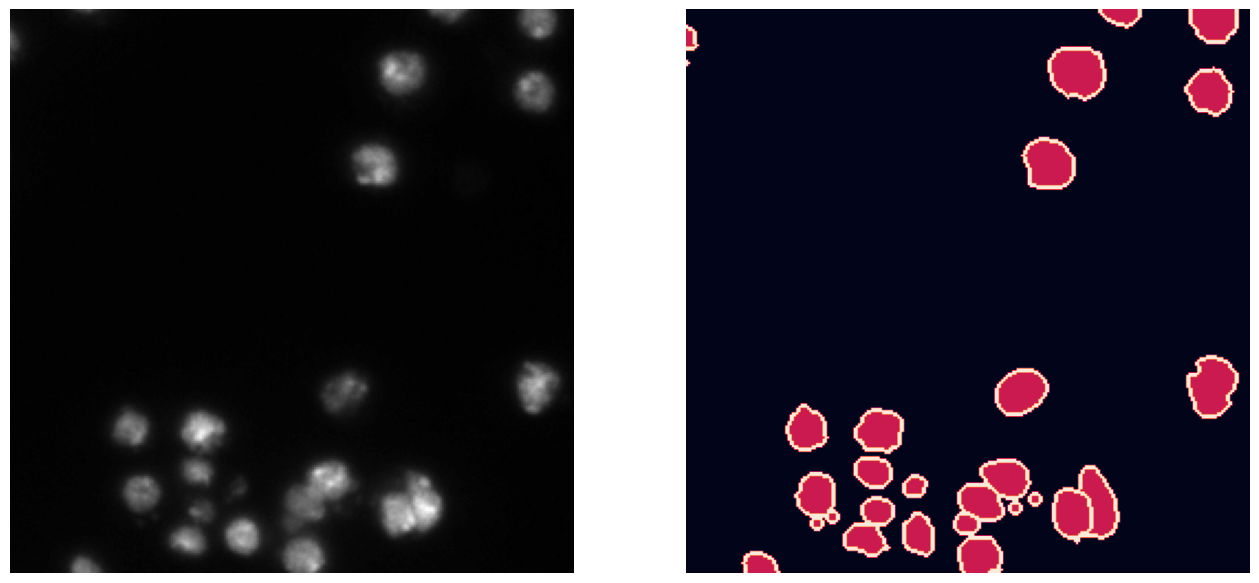

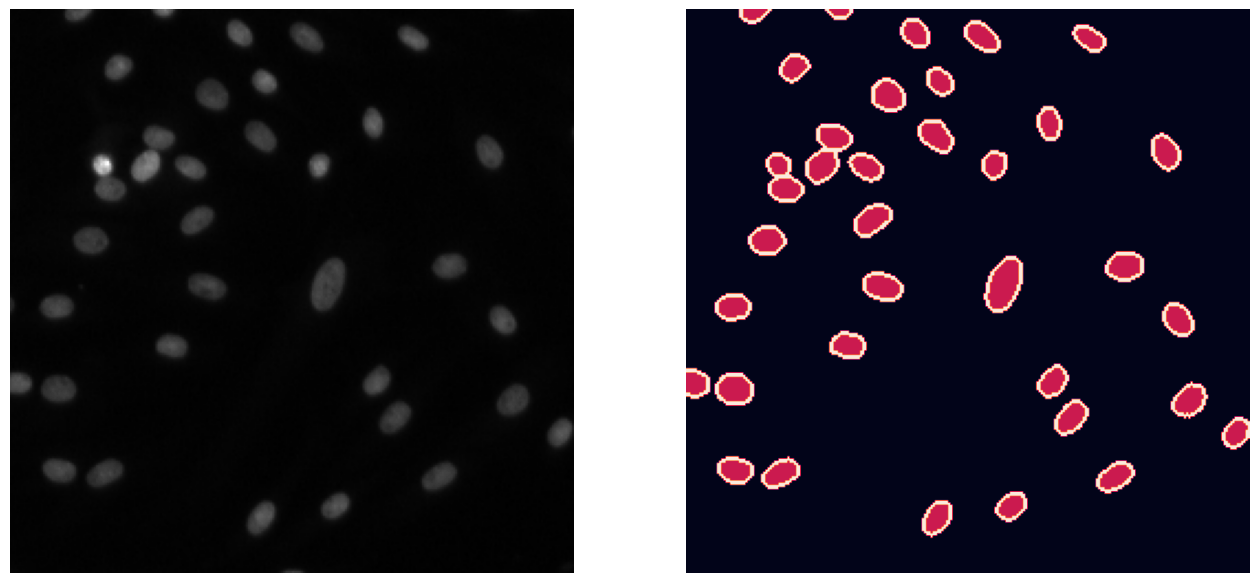

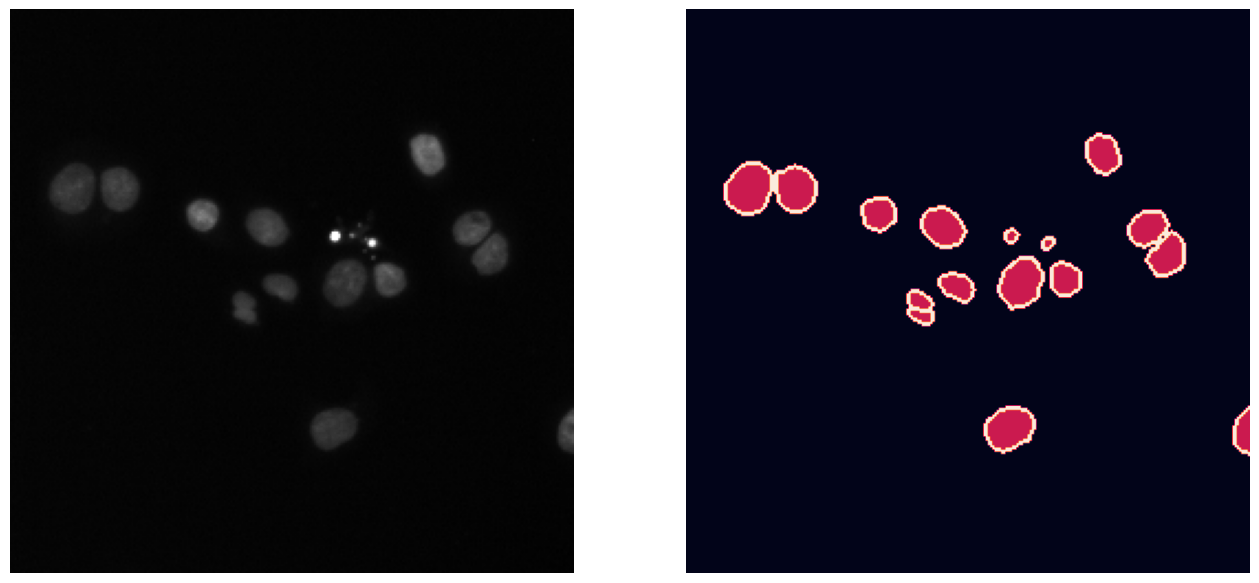

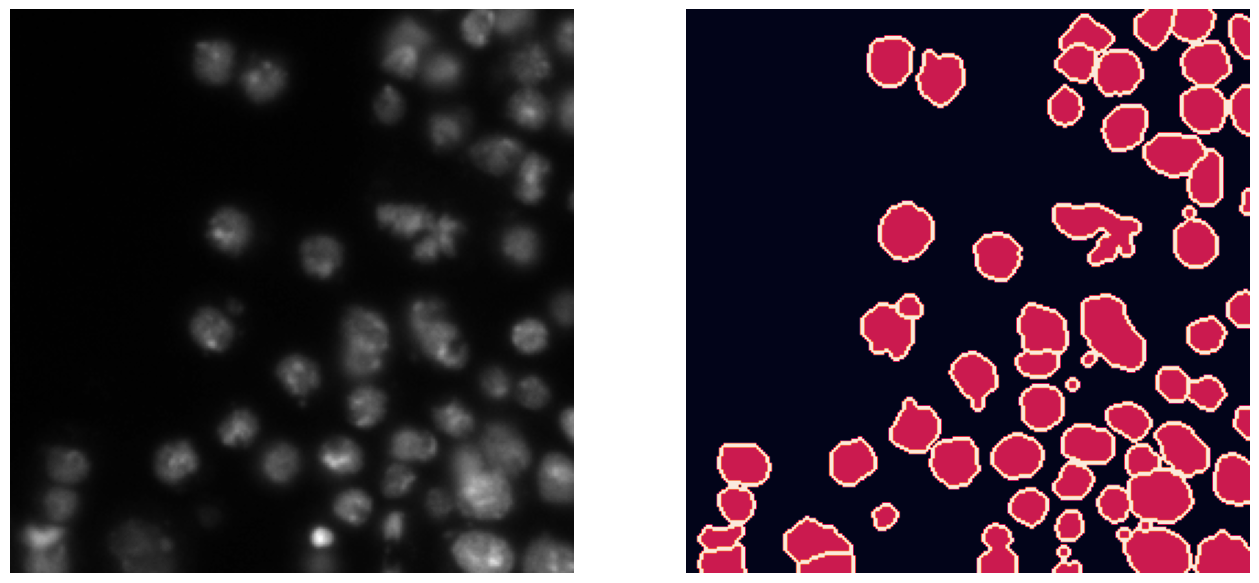

In [165]:
# We visualize the new label transform and make sure it's correct
counter = 0
for im, target in train_dataset:
    if counter > 3:
        break
    fig, ax = plt.subplots(1, 2, figsize=(16, 16))
    ax[0].axis("off")
    ax[0].imshow(im[0], cmap="gray")
    ax[1].axis("off")
    ax[1].imshow(target)
    plt.show()
    counter += 1

In [180]:
# We instantiate the new unet and loss function
model = UNet(out_channels=3)
model.to(device)
loss = nn.CrossEntropyLoss()

100%|██████████| 10/10 [02:48<00:00, 16.86s/it]


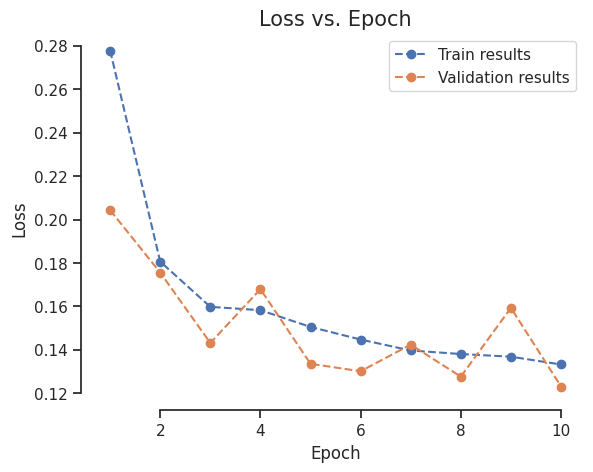

In [181]:
# We train the new U-Net for 10 epochs
# (we don't use a metric here, since the target (with class labels 0, 1, 2) and prediction (one-hot encoding) have different representations
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None
train_losses, _, val_losses, _ = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)

**Instance segmentation via watershed:**

We now want to use the predictions for background, foreground and boundary to better separate the nuclei than before using the following approach:
- Subtract the boundary prediction from the foreground prediction to separate touching nuclei from each other.
- Apply connected components to the result to get the "core" of the now separated nuclei.
- Grow these nucleus cores back to the full outlines.
    - For this step we will use the watershed algorithm, which segments images based on a height-map and markers.
    - The markers define the core of regions and they are grown by this algorithm until two markers meet at the highest point between them (defined by the heightmap).
- We will restrict the watershed to the foreground, so that nuclei don't spill over into the background. 

**Let's visualize these steps to better understand them:**

- We are given the foreground and boundary predictions from the model:

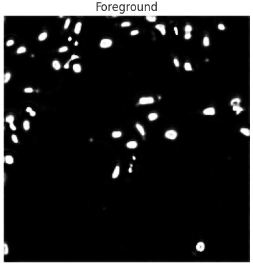 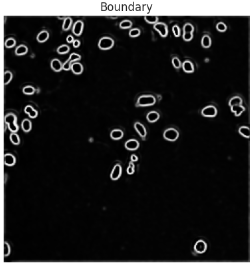

- Subtract the boundaries from the foreground predictions (left image), threshold the result (not shown) and apply connected components to generate the markers (right image):

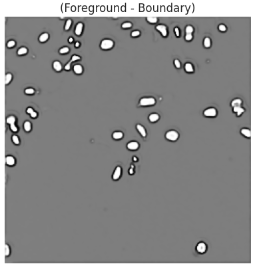 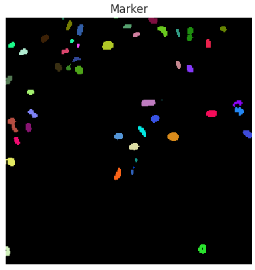

- This provides us with all three inputs for the watershed:
    - The boundary predictions from the network can be used as heightmap (because they separate the nuclei). (left image)
    - The markers that we have just computed (middle image)
    - The thresholded foreground predictions, which we use as mask for the watershed. (right image)

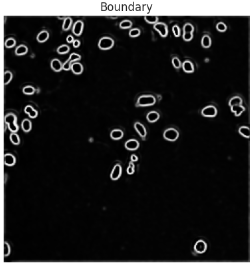 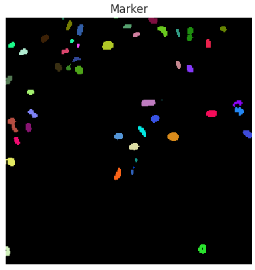 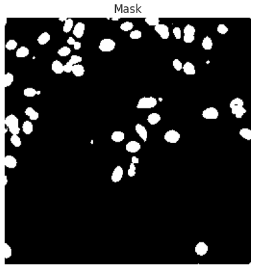


In [198]:
# We implement the watershed approach described above.
def instance_segmentation(foreground_prediction, boundary_prediction, threshold=0.5):
    # Subtract the boundary prediction from the foreground prediction
    separated_nuclei = foreground_prediction - boundary_prediction
    # Threshold the separated nuclei to create a binary image
    binary_nuclei = (separated_nuclei > threshold).astype(np.int64)
    # Label connected components as markers for watershed
    markers = label(binary_nuclei)
    
    # Use the boundary prediction as a heightmap for watershed
    heightmap = boundary_prediction  
    
    # Use the thresholded foreground predictions as a mask to restrict watershed
    mask = (foreground_prediction > threshold).astype(np.int64)
    
    # Apply the watershed algorithm
    ws_labels = watershed(heightmap, markers, mask=mask)
    
    return ws_labels

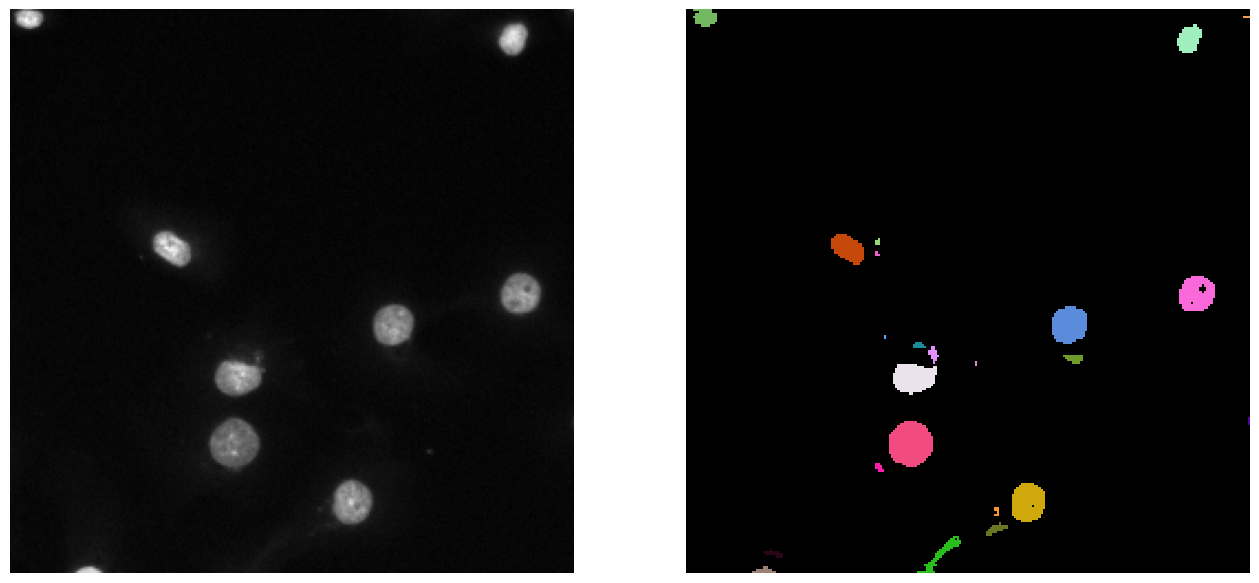

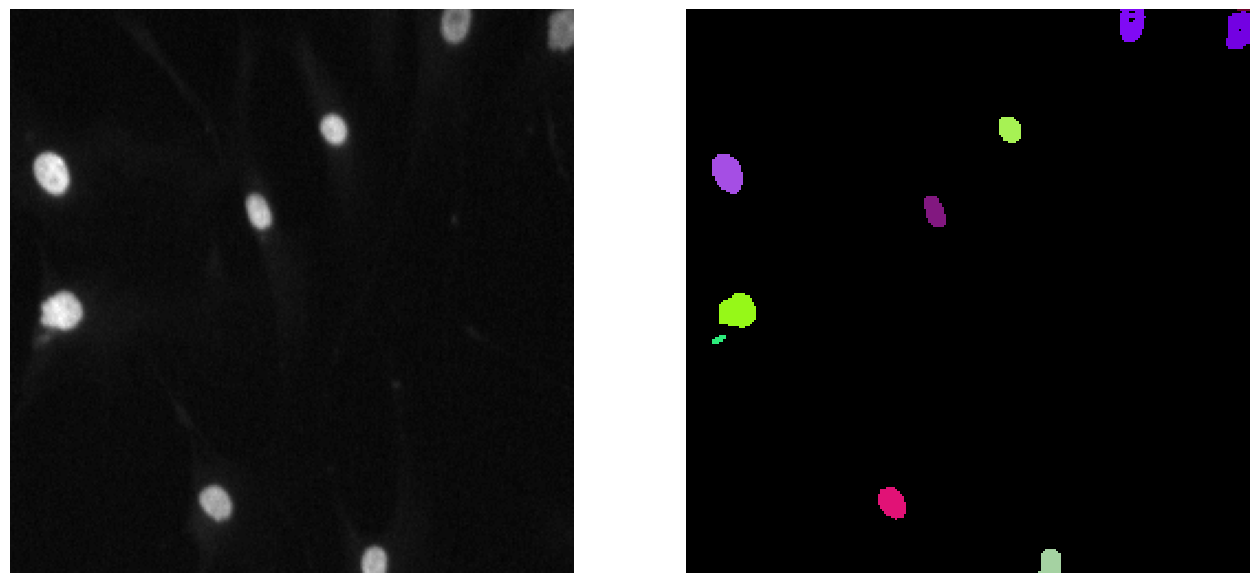

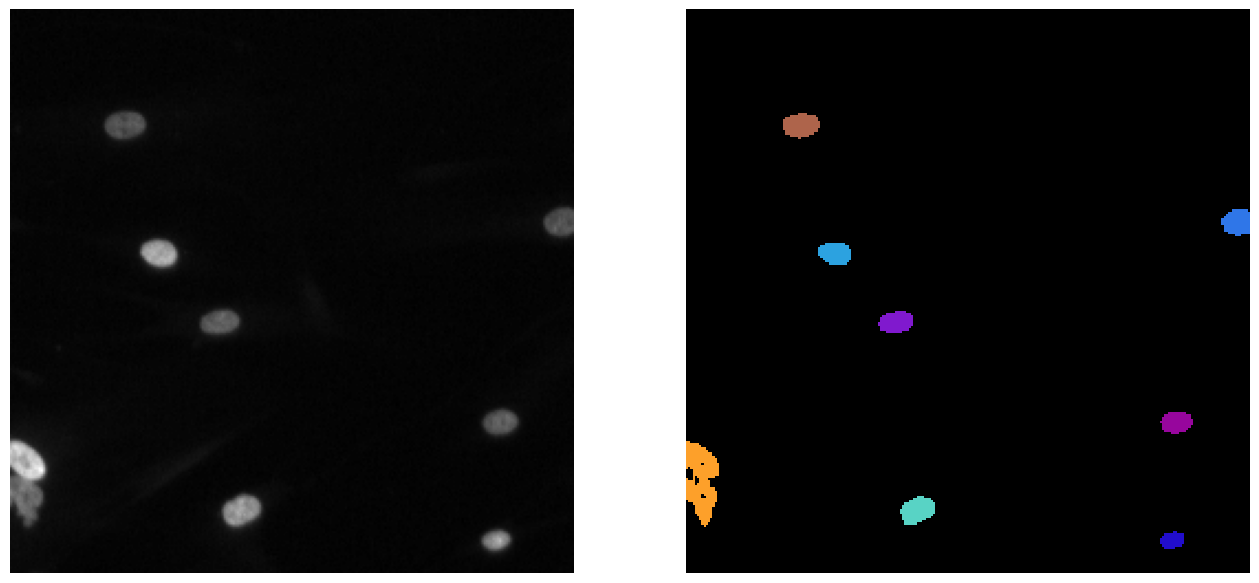

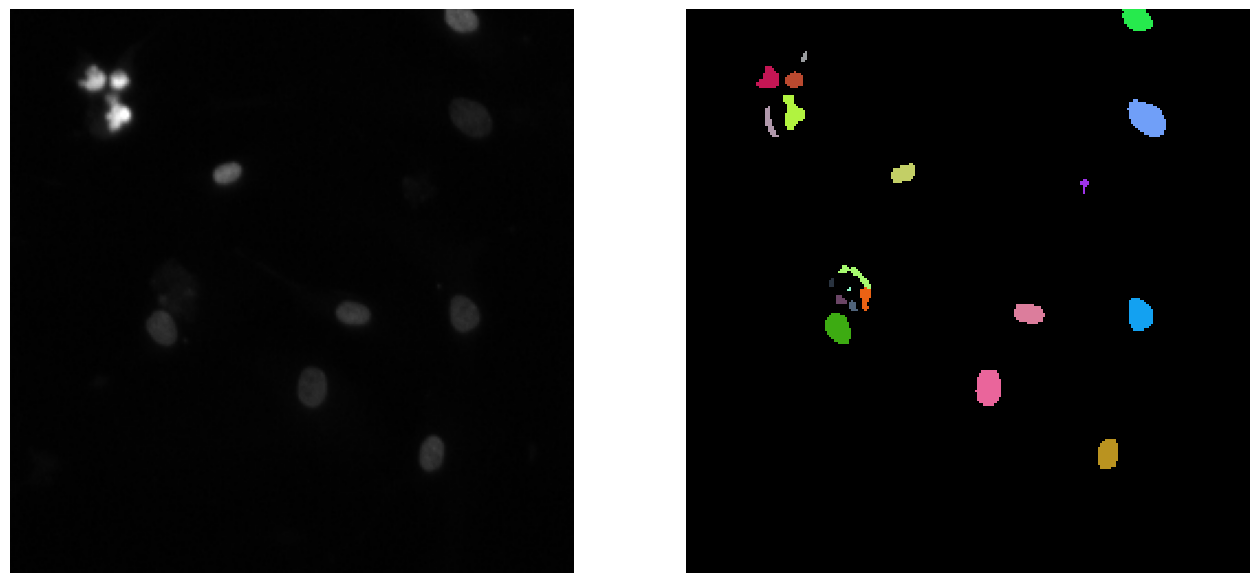

In [199]:
# We check the prediction results and instance segmentation for a few images
# make sure your instance segmentation implementation is correct
# HINT: you need to apply a softmax to the network predictions 
counter = 0
with torch.no_grad():
    for im, mask in val_loader:
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(im.to(device))
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = instance_segmentation(pred[1], pred[2], threshold=0.5)
        fig, ax = plt.subplots(1, 2, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im.squeeze().squeeze(), cmap="gray")
       
        ax[1].axis("off")
        ax[1].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        
    
        plt.show()
        counter += 1

In [200]:
# We use the validation set to find a good value for the 'threshold' parameter in the instance_segmentation function
# Define a range of possible thresholds to test
thresholds = np.linspace(0.1, 0.9, 9)

# Initialize a dictionary to hold the average F1 scores for each threshold
threshold_scores = {}

with torch.no_grad():
    for threshold in thresholds:
        f1_scores = []
        for im, mask in val_loader:
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        # Iterate over all threshold values
            pred = model(im.to(device))
            pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
            # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
            nuclei = instance_segmentation(pred[1], pred[2], threshold)
            mask = mask.numpy().squeeze()
            f1_sc = f1_score(nuclei, mask, threshold)
            f1_scores.append(f1_sc)
    
        # Compute the average F1 score across the validation set for this threshold
        threshold_scores[threshold] = np.mean(f1_scores)
        
# Find the threshold with the best average F1 score
best_threshold = max(threshold_scores, key=threshold_scores.get)
# print(threshold_scores)
print(f"Best threshold: {best_threshold} with average F1 score: {threshold_scores[best_threshold]}")

Best threshold: 0.1 with average F1 score: 0.08675808897658893


In [201]:
# We compute the average f1 score of all the test images
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # 
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])
        f1s.append(f1_score(nuclei, mask, best_threshold))
print()
print(np.mean(f1s))

100%|██████████| 50/50 [00:02<00:00, 21.13it/s]



0.7496637361310937


Speaking in terms of the f1 score on the test set, training with boundaries does in fact improve the results. However, looking at some of the predicted masks (post-instance segmented), the results are still quite far from perfect.

## Use the dice coefficient as loss function

Since our target is quite unbalanced (in particular the boundary channel), it is beneficial to use a loss function that is robust against class imbalance. In this part of the exercise we will use the Dice coefficient as loss. We have already used it as a metric before.

Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [15]:
# We implement a loss function based on the dice coefficient

def dice_score_new(input_, target):
    # Check if multi-class or binary segmentation
    num_classes = input_.shape[1]

    if num_classes == 1:
        # Binary segmentation
        input_sigmoid = torch.sigmoid(input_)
        intersection = (input_sigmoid * target).sum(dim=(2, 3))
        union = input_sigmoid.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    else:
        # Multi-class segmentation
        # One-hot encode target to match input shape
        target_one_hot = F.one_hot(target.long(), num_classes=num_classes)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2)  # Rearrange dimensions

        # Apply softmax to predictions
        input_softmax = F.softmax(input_, dim=1)

        # Calculate intersection and union for each class
        intersection = (input_softmax * target_one_hot).sum(dim=(2, 3))
        union = input_softmax.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    # Compute Dice score
    dice = (2. * intersection + 1e-6) / (union + 1e-6)

    # Compute average over channels
    dice_score_average = dice.mean(dim=1)
    return dice_score_average.mean()

def dice_loss(pred, target):
    return 1 - dice_score_new(pred, target)

100%|██████████| 10/10 [02:47<00:00, 16.70s/it]


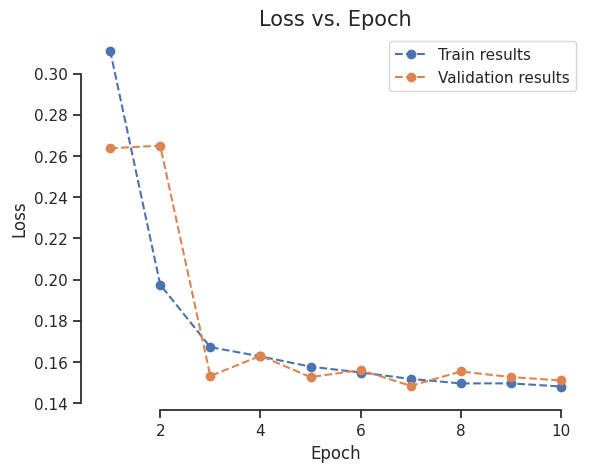

In [220]:
# We implement and compare with different loss function variations
model = UNet(out_channels=3)
model.to(device)
loss = dice_loss
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None
train_losses, _, val_losses, _ = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)

In [224]:
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # 
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])
        f1s.append(f1_score(nuclei, mask, best_threshold))
print()
print(np.mean(f1s))

100%|██████████| 50/50 [00:02<00:00, 23.90it/s]



0.8758825070332137


On training the model with the dice loss, we get a better overall f1 score ($\approx$ 0.88) on the test dataset, as compared to when training it with the CrossEntropyLoss ($\approx$ 0.75).